In [1]:
import sys
import pyfftw

import ROOT
from ROOT import gROOT
from ROOT import gStyle
%jsroot on

ROOT.gInterpreter.AddIncludePath('../../include/')
ROOT.gInterpreter.Declare('#include "RoEvent.h"')
ROOT.gSystem.Load('../../libs/libRoEvent.so')

gROOT.LoadMacro("../style/CMS/tdrstyle.C")
gROOT.ProcessLine("setTDRStyle();")
gROOT.LoadMacro("../style/CMS/CMS_lumi.C")

import pickle
from array import array
from pathlib import Path
import numpy as np
from scipy import signal
sys.path.append("../package/")
import lycro 

gStyle.SetOptFit(0)

Welcome to JupyROOT 6.24/00


In [2]:
card = "AMC-106"; run = 814; thr = 70; pad = 50
pol = -1; N = 10000; step = 1000; percent = 0.01

chs = range(0, 32); side = "Short"
#chs = range(32, 64); side = "Long"
chs_t = chs
dump = 1
elog = """\\url{https://elog.ip2i.in2p3.fr/wa105/Preparation+CB/25}"""
date = "June 2021"
place = "Lyon"
zoom_neg = -200; zoom_pos = 200
pick = "../../tmp/ju_r" + str(run) + "_thr-" + str(thr) + "_pad-" + str(pad) + ".pik"
root = "../../tmp/ro_r" + str(run) + ".root"
print("PICK file: {}".format(pick))
print("ROOT file: {}".format(root))
Path("../../tmp/r" + str(run)).mkdir(parents=True, exist_ok=True)
Path("../../tmp/r" + str(run) + "/fig").mkdir(parents=True, exist_ok=True)
pathToSave = "../../tmp/r" + str(run) + "/fig/"
pdfpol = "Pos"
if(pol == -1):
    pdfpol = "Neg"
pdf = "../../tmp/r" + str(run) + "/viewer_r" + str(run) + "_" + side + "_" + pdfpol + ".tex"
print("PDF file: {}".format(pdf))

# read ju_signals
ju_signals = []
with open(pick, "rb") as f:
    for _ in range(pickle.load(f)):
        ju_signals.append(pickle.load(f))  
print(len(ju_signals))

PICK file: ../../tmp/ju_r814_thr-70_pad-50.pik
ROOT file: ../../tmp/ro_r814.root
PDF file: ../../tmp/r814/viewer_r814_Short_Neg.tex
28000


In [3]:
ped, _ = lycro.pedestal(ju_signals, pad = pad)
prof, prof_N = lycro.profile(ju_signals, pol = pol, pad = pad)

ped_aling, ped_avg = lycro.pedestal(ju_signals, pad = pad, align = 1)

gr_ped_avg, avgped = lycro.average(ped_avg)
prof_correct, correct_N = lycro.profile(ju_signals, pol = pol, pad = pad, align = 0, avgped = avgped)
prof_cut = lycro.cutProf(prof_correct, pol = pol, pad = pad)

Warning in <TROOT::Append>: Replacing existing TH1: pedesta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: profile_neg (Potential memory leak).


In [4]:
chs_thr, min_thr, max_thr = lycro.filter(ju_signals, prof_cut, chs, pol = pol, N = N, step = step)
print(len(chs), chs)
print(len(chs_thr), chs_thr)
prof_final_N, prof_final, gr_h, gr_sum, h_sum, h_avg = lycro.profSumHeight(ju_signals, pol = pol, pad = pad, align = 0, chs = chs, chs_thr = chs_thr)

32 range(0, 32)
32 [32255, 18867, 43372, 21166, 36314, 27334, 42346, 22435, 43572, 40252, 56915, 38513, 55466, 40106, 55247, 33536, 34348, 42920, 58885, 31012, 40720, 38625, 41861, 30168, 29437, 18198, 43571, 32366, 27426, 32423, 46793, 31352]


In [6]:
ptype = "profile"

name = "prof_final"; title = "run {} | {} | {} | {} | Profile of signals after filtering N={}".format(run, card, side, pdfpol, prof_final_N)
lycro.plot(prof_final, name, title, pathToSave, ptype, "tick", "ADCu", -2048, 2048, 0, 2*pad)
name = "prof_final_zoom"; title = "run {} | {} | {} | {} | (ZOOM) Profile of signals after filtering N={}".format(run, card, side, pdfpol, prof_final_N)
lycro.plot(prof_final, name, title, pathToSave, ptype, "tick", "ADCu", zoom_neg, zoom_pos, 0, 2*pad)

name = "profile"; title = "run {} | {} | {} | {} | Profile of all signals N={}".format(run, card, side, pdfpol, prof_N)
lycro.plot(prof, name, title, pathToSave, ptype, "tick", "ADCu",-2048, 2048, 0, 2*pad)
name = "profile_zoom"; title = "run {} | {} | {} | {} | (ZOOM) Profile of all signals N={}".format(run, card, side, pdfpol, prof_N)
lycro.plot(prof, name, title, pathToSave, ptype, "tick", "ADCu", zoom_neg, zoom_pos, 0, 2*pad)

name = "height"; title = "(height) run {} | {} | {} | {}".format(run, card, side, pdfpol)
lycro.plot(gr_h, name, title, pathToSave, "hsum", "chid", "height",1, -1, 1, -1)
name = "sum"; title = "(sum) run {} | {} | {} | {}".format(run, card, side, pdfpol)
lycro.plot(gr_sum, name, title, pathToSave, "hsum", "chid", "sum", 1, -1, 1, -1)
figs = []
fig_sum = []
fig_height = []
if(dump):
    for sig in ju_signals:
        index = 0; index = chs.index(sig.ch)
        if(sig.unequal == 1 and sig.overlap < (min_thr[index] + (chs_thr[index] - min_thr[index])*percent)):
            ch = sig.ch
            ev = sig.ev
            name = "run" + str(run) + "_ch" + str(ch) + "_ev" + str(ev)
            cro = lycro.findCRO(root, ev, ch)

            d_cro = array('f'); d_tick = array('f'); err = array('f')
            for sa in range(len(cro)):
                d_cro.append(cro[sa])
                d_tick.append(sa)
                err.append(0)
            gr = ROOT.TGraphErrors(len(d_tick), d_tick, d_cro, err, err)
            gr.SetTitle("gr_" + name); gr.SetName("gr_" + name)
            gr.GetXaxis().SetTitle("tick"); gr.GetYaxis().SetTitle("ADCu")
            title = name + "        "
            lycro.plot(gr, name, title, pathToSave, "event", "tick", "ADCu", 0, 4096, 0, 10000)
            figs.append(name);       
    
    for h in range(len(h_sum)):
        lycro.plot(h_sum[h], h_sum[h].GetName(), "run {} | {} | {} | {} | {} | mean {:02f} | rms {:02f}".format(run, card, side, pdfpol, h_sum[h].GetName(), h_sum[h].GetMean(), h_sum[h].GetRMS()), pathToSave, "", "sum", "entries", 1, -1, 1, -1)  
        fig_sum = [h_sum[h].GetName()]
    for h in range(len(h_avg)):
        lycro.plot(h_avg[h], h_avg[h].GetName() , "run {} | {} | {} | {} | {} | mean {:02f} | rms {:02f}".format(run, card, side, pdfpol, h_avg[h].GetName(), h_avg[h].GetMean(), h_avg[h].GetRMS()), pathToSave, "", "height", "entries", 1, -1, 1, -1)  
        fig_height.append(h_avg[h].GetName())
        #######
name = "profile_cut"; title = "Cut".format(prof_N)
lycro.plot(prof_cut, name, title, pathToSave, ptype, "tick", "ADCu",-2048, 2048, 0, 2*pad)
name = "profile_cut_zoom"; title = "(ZOOM) Cut".format(prof_N)
lycro.plot(prof_cut, name, title, pathToSave, ptype, "tick", "ADCu", zoom_neg, zoom_pos, 0, 2*pad)

name = "mainProf"; title = "#bf{Profile of all signals}"
lycro.plot(prof_correct, name, title, pathToSave, ptype, "tick", "ADCu", -2048, 2048, 0, 2*pad)
name = "mainProf_zoom"; title = "#bf{Profile of all signals (ZOOM)}"
lycro.plot(prof_correct, name, title, pathToSave, ptype, "tick", "ADCu", -200, 200, 0, 2*pad)

name = "pedestal"; title = "#bf{Profile of all pedestal}"
lycro.plot(ped, name, title, pathToSave, ptype, "tick", "ADCu", -2048, 2048, 0, 2*pad)
name = "pedestal_zoom"; title = "#bf{Profile of all pedestal (ZOOM)}"
lycro.plot(ped, name, title, pathToSave, ptype, "tick", "ADCu", -50, 50, 0, 2*pad)

name = "pedestal_aling"; title = "#bf{Profile of all pedestal Aling}"
lycro.plot(ped_aling, name, title, pathToSave, ptype, "tick", "ADCu", -2048, 2048, 0, 2*pad)
name = "pedestal_aling_zoom"; title = "#(ZOOM) bf{Profile of all pedestal Aling}"
lycro.plot(ped_aling, name, title, pathToSave, ptype, "tick", "ADCu", -50, 50, 0, 2*pad)
print("DONE")

DONE
run 814 | AMC-8 | Short | Neg | Profile of signals after filtering N=12000            
run 814 | AMC-8 | Short | Neg | (ZOOM) Profile of signals after filtering N=12000            
run 814 | AMC-8 | Short | Neg | Profile of all signals N=12000            
run 814 | AMC-8 | Short | Neg | (ZOOM) Profile of all signals N=12000            
(height) run 814 | AMC-8 | Short | Neg
(sum) run 814 | AMC-8 | Short | Neg
run 814 | AMC-8 | Short | Neg | sum_ch0 | mean 689.667680 | rms 55.473584
run 814 | AMC-8 | Short | Neg | sum_ch1 | mean 720.989173 | rms 59.746286
run 814 | AMC-8 | Short | Neg | sum_ch2 | mean 715.774613 | rms 60.545972
run 814 | AMC-8 | Short | Neg | sum_ch3 | mean 693.638987 | rms 60.389600
run 814 | AMC-8 | Short | Neg | sum_ch4 | mean 694.437120 | rms 62.774011
run 814 | AMC-8 | Short | Neg | sum_ch5 | mean 699.797227 | rms 60.161822
run 814 | AMC-8 | Short | Neg | sum_ch6 | mean 680.699680 | rms 61.091031
run 814 | AMC-8 | Short | Neg | sum_ch7 | mean 683.004320 | rms 

Info in <TH2D::SaveAs>: ROOT file ../../tmp/r814/fig/prof_final.root has been created
Info in <TCanvas::Print>: SVG file ../../tmp/r814/fig/prof_final.svg has been created
Info in <TCanvas::Print>: pdf file ../../tmp/r814/fig/prof_final.pdf has been created
Info in <TH2D::SaveAs>: ROOT file ../../tmp/r814/fig/prof_final_zoom.root has been created
Info in <TCanvas::Print>: SVG file ../../tmp/r814/fig/prof_final_zoom.svg has been created
Info in <TCanvas::Print>: pdf file ../../tmp/r814/fig/prof_final_zoom.pdf has been created
Info in <TH2D::SaveAs>: ROOT file ../../tmp/r814/fig/profile.root has been created
Info in <TCanvas::Print>: SVG file ../../tmp/r814/fig/profile.svg has been created
Info in <TCanvas::Print>: pdf file ../../tmp/r814/fig/profile.pdf has been created
Info in <TH2D::SaveAs>: ROOT file ../../tmp/r814/fig/profile_zoom.root has been created
Info in <TCanvas::Print>: SVG file ../../tmp/r814/fig/profile_zoom.svg has been created
Info in <TCanvas::Print>: pdf file ../../tmp

In [7]:
def figure(path2First, path2Second, caption, label):
    output = "\\begin{figure}[h!]\n"
    output += "\\begin{minipage}[h]{0.47\linewidth}\n"
    
    output += "\\center{\includegraphics[width=1\linewidth]{"
    output += path2First
    output += "}} \n"
    
    output += "\\end{minipage} \n"
    output += "\\hfill \n"
    output += "\\begin{minipage}[h]{0.47\linewidth} \n"
    
    output += "\\center{\includegraphics[width=1\linewidth]{"
    output += path2Second
    output += "}} \n"
    
    output += "\\end{minipage} \n"
    
    output += "\\caption{"
    output += caption
    output += "} \n"
    
    output += "\\label{"
    output += label
    output += "} \n"
    
    output += "\\end{figure} \n"
    output += "\\FloatBarrier \n"
    
    return output

def event_figure(path):
    output = "\\begin{figure}[!ht]\n"
    
    output += "\\center{\includegraphics[width=0.9\linewidth]{"
    output += path
    output += "}} \n" 
    
    output += "\\end{figure} \n"
    output += "\\FloatBarrier \n"
    
    return output


with open(pdf,'w') as file:
    file.write('\\documentclass[12pt, a4paper]{article}\n')
    file.write('\\usepackage[utf8]{inputenc}\n')
    file.write('\\usepackage[english]{babel}\n')
    file.write('\\usepackage[T1]{fontenc}\n')
    file.write('\\usepackage{graphicx}\n')
    file.write('\\usepackage{geometry}\n')
    file.write('\\usepackage{color,soul}\n')
    file.write('\\DeclareRobustCommand{\hlcyan}[1]{{\sethlcolor{cyan}\hl{#1}}}\n')
    file.write('\\usepackage[document]{ragged2e}\n')
    file.write('\\usepackage{array}\n')
    file.write('\\usepackage{graphicx}\n')
    file.write('\\usepackage{placeins}\n')
    file.write('\\usepackage{amssymb}\n')
    file.write('\\usepackage{wrapfig}\n')
    file.write('\\usepackage{hyperref}\n')
    file.write('\\usepackage{listings}\n')
    
    file.write('\\newcommand{\+}[1]{\ensuremath{\mathbf{#1}}}\n')
    file.write('\\geometry{top=2.5cm, bottom=2.5cm, right=2.5cm, left=2.5cm}\n')
    percent
    file.write('\\begin{document}\n')
    file.write('\\noindent Institut de Physique des 2 Infinis de Lyon \hfill Date, Place \\\\ \n')
    file.write('\\noindent Shchablo Konstantin (shchablo@gmail.com) \hfill ' + date + ', ' + place  + ' \\\\ \n')
    file.write('\\center\n')
    namepol = "Positive"
    if(pol == -1):
        namepol = "Negative"
    file.write('\\section*{Signal View: Run-' + str(run) + " " + card  +  " " + side + " " + namepol + '}\n')
    file.write('ELOG: ' + elog +'\n')
    
    file.write('\\justify\n')
    file.write('The processing includes filtering based on the selection of the signals that correspond to the most common pattern. The pedestal corrected with a spectrum subtraction algorithm.  The height found with help of the resampling method. The sum calculated as the integral of the signal in the given window.\n')
    file.write('\\\\ \\\\ GitHub: (https://github.com/shchablo/CRO)\n')   
    
    file.write('\\tableofcontents\n')
    
    file.write('\\newpage\n')
    #file.write('\\newcommand{\+}[1]{\ensuremath{\mathbf{#1}}}\n')
    file.write('\\section{Results: Profile; Filtered Profile; Height; Sum.}\n')
    file.write(figure( "./fig/height.pdf", "./fig/sum.pdf", "File: height and sum.", "hsum"))
    file.write(figure( "./fig/prof_final.pdf", "./fig/prof_final_zoom.pdf", "File: Prof Final.", "prof_final"))
    file.write(figure( "./fig/profile.pdf", "./fig/profile_zoom.pdf", "File: Profile.", "profile"))
    
    file.write('\\newpage\n')
    file.write('\\section{Pedestal; Cut Profile; }\n')
    file.write(figure( "./fig/profile_cut.pdf", "./fig/profile_cut_zoom.pdf", "File: Profile Cut.", "profile_cut"))
    file.write(figure( "./fig/pedestal.pdf", "./fig/pedestal_zoom.pdf", "File: Pedestal.", "pedestal"))
    file.write(figure( "./fig/pedestal_aling.pdf", "./fig/pedestal_aling_zoom.pdf", "File: Pedestal Aling.", "paling"))
    
    file.write('\\section{Height.}\n')
    
    for f in fig_height:
        file.write(event_figure("./fig/" + f + ".pdf"))
    
    file.write('\\section{Integral.}\n')
    
    for f in fig_sum:
        file.write(event_figure("./fig/" + f + ".pdf"))
    
    value = prof_N - prof_final_N
    file.write('\\section{Examples of some filtered event (In total filtered ' + str(value)  + '). }\n')
    if(dump):
        for f in figs:
            file.write(event_figure("./fig/" + f + ".pdf"))
    
    file.write('\\end{document}\n')
print("DONE")

DONE


8731
49


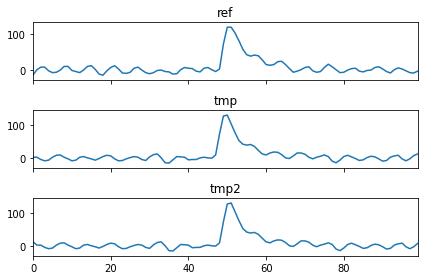

In [17]:
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
####################################################################################################################
from scipy import signal

print(len(ju_signals))
if(len(ju_signals) > 0): ref = ju_signals[0].data
tmp = ju_signals[5].data
conv  = signal.convolve(tmp, ref[::-1], mode='same')

import matplotlib.pyplot as plt

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)

ax_orig.plot(ref)
ax_orig.set_title('ref')
ax_orig.margins(0, 0.1)

ax_win.plot(tmp)
ax_win.set_title('tmp')
ax_win.margins(0, 0.1)

index = np.argmax(conv)
print(index)
tmp = np.roll(tmp, pad-index)

conv  = signal.convolve(tmp, ref[::-1], mode='same') 

ax_filt.plot(tmp)
ax_filt.set_title('tmp2')
ax_filt.margins(0, 0.1)

fig.tight_layout()
fig.show()
